In [1]:

from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.validation as mv
import mytf.plot as mp

1.14.0


Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()

In [ ]:
# Try different learning rates...?
# Hmmm try the stacked lstm architecture from the machine learning mastery DL book.


In [7]:
# Use datasets from 
# 2019-12-25.ipynb
# 
# train ... new datasets, ...
outdir = 'history/2019-12-22T174803Z'
train_loc = f'{outdir}/train_balanced.h5'
test_loc = f'{outdir}/test_balanced.h5'
train_shuff_loc = f'{outdir}/train_scaled_balanced_shuffled.h5'
print(mu.h5_keys(train_shuff_loc))
print(mu.h5_keys(test_loc))

X, Ylabels = mu.read_h5_two(
                source_location=train_shuff_loc, 
                Xdataset=f'X',
                Ydataset=f'Ylabels')

['X', 'Ylabels']
['X_0', 'X_1', 'X_2', 'X_3', 'Ylabels_0', 'Ylabels_1', 'Ylabels_2', 'Ylabels_3']


In [10]:
class_weights = {0: 1., 1: 1., 2: 1., 3: 1.}
size = X.shape[0]
train_vec, label_vec, weights_vec = \
            mu.helper_build_dataset_weighty_v3(
    arrays={'x_train': X,
         'ylabels_train': Ylabels}, 
    target_indices=list(range(size)), 
    class_weights=class_weights,
    batch_size=32)


# dataset_batches = mu.build_dataset_weighty_v3(
#        {'x_train': X,
#         'ylabels_train': Ylabels},
#        list(range(size)), 
#        class_weights=class_weights,
#        batch_size=BATCH_SIZE)

/home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py:185: RuntimeWarning: divide by zero encountered in true_divide
  )/class_counts


In [32]:
print(X.shape, Ylabels.shape)
print(len(train_vec), size/32)
print(train_vec[0].shape)
#print(type(label_vec[0]))
print(train_vec[0].shape, label_vec[0].shape)
print(weights_vec[200])
print(Counter(Ylabels))
print((label_vec[2]))

(34980, 64, 8) (34980,)
1094 1093.125
(32, 64, 8)
(32, 64, 8) (32,)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Counter({0.0: 10230, 3.0: 8839, 2.0: 8286, 1.0: 7625})
[0. 1. 1. 3. 2. 2. 2. 3. 1. 0. 1. 3. 2. 0. 1. 2. 2. 0. 0. 3. 0. 1. 3. 0.
 3. 0. 2. 2. 3. 3. 1. 1.]


In [45]:
# Working dir... for new model
save_dir = 'history'
ts = mu.quickts(); print('starting,', ts)

size = X.shape[0]
workdir = f'{save_dir}/{ts}'
os.mkdir(workdir)
print(f'Made new workdir, {workdir}')

starting, 2019-12-28T184817Z
Made new workdir, history/2019-12-28T184817Z


In [58]:
type(Ylabels[0]), type(X[0][0][0])

(numpy.float64, numpy.float64)


##### InternalError
I think since this time I had loaded a previously saved shuffled balanced data, 
I'm seeing it is float64. maybe thats why I'm getting this `InternalError` about the types.. 

```
type(Ylabels[0]), type(X[0][0][0])
(numpy.float64, numpy.float64)

InternalError: Could not find valid device for node.
Node: {{node SparseSoftmaxCrossEntropyWithLogits}}
All kernels registered for op SparseSoftmaxCrossEntropyWithLogits :
  device='XLA_CPU'; Tlabels in [DT_INT32, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_BFLOAT16, DT_HALF]
  device='CPU'; T in [DT_HALF]; Tlabels in [DT_INT64]
  device='CPU'; T in [DT_HALF]; Tlabels in [DT_INT32]
  device='CPU'; T in [DT_DOUBLE]; Tlabels in [DT_INT64]
  device='CPU'; T in [DT_DOUBLE]; Tlabels in [DT_INT32]
  device='CPU'; T in [DT_FLOAT]; Tlabels in [DT_INT64]
  device='CPU'; T in [DT_FLOAT]; Tlabels in [DT_INT32]
  device='XLA_CPU_JIT'; Tlabels in [DT_INT32, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_BFLOAT16, DT_HALF]
 [Op:SparseSoftmaxCrossEntropyWithLogits] name: xentropy
```

##### instead...
```
type(Ylabels[0].astype('int64')), type(X[0][0][0])
```
Okay.. when I passed that, this worked now.

In [48]:
# Parameters..

# 'batch_size'
BATCH_SIZE = 32
# 
# ValueError: If a RNN is stateful, it needs to know its batch size. Specify the batch size of your input tensors: 
# - If using a Sequential model, specify the batch size by passing a `batch_input_shape` argument to your first layer.
# - If using the functional API, specify the batch size by passing a `batch_shape` argument to your Input layer.

lstm_params = [{
    'units': 64,
    'dropout': 0.5,
    'recurrent_dropout': 0.5,
    'batch_input_shape': (BATCH_SIZE, 64, 8),
    'stateful': True,
    'return_sequences': True,
    },
    {'units': 64,
    'dropout': 0.5,
    'recurrent_dropout': 0.5,
    'batch_input_shape': (BATCH_SIZE, 64, 8),
    'stateful': True,
    },

]

optimizer_params = {
    'learning_rate': 0.001,  
    'beta1': 0.9, 
    'beta2': 0.999, 
    'epsilon': 1e-08
}

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(**lstm_params[0]),
    tf.keras.layers.LSTM(**lstm_params[1]),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)])

# save base unfitted model.
mu.save_model(model=model, 
              loc=f'{workdir}/00000__unfitted_model.h5')

In [59]:


model = mu.load_model(f'{workdir}/00000__unfitted_model.h5')

class_weights = {0: 1., 1: 1., 2: 1., 3: 1.}
dataset_batches = mu.build_dataset_weighty_v3(
        {'x_train': X,
         'ylabels_train': Ylabels.astype('int64')},
        list(range(size)), 
        class_weights,
        batch_size=BATCH_SIZE)
    
#with ipdb.launch_ipdb_on_exception():
mu.do_train(
        model,
        dataset_batches,
        k=size,
        saveloc=workdir)

W1228 19:02:40.161912 139664612869952 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
/home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py:185: RuntimeWarning: divide by zero encountered in true_divide
  )/class_counts
0it [00:00, ?it/s]W1228 19:02:40.976063 139664612869952 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1093it [15:51,  1.14it/s]

InvalidArgumentError: Incompatible shapes: [4,64] vs. [32,64] [Op:Add] name: sequential_2/lstm_11/add/

#### Crashed last batch but thats okay
So this time around since I did a stacked lstm, the very last batch failed because it was not 
the same size as the batch size I specified. It is luckily okay though, because
I save my models and train losses to a file these days . So literally 99.9% of the models were saved. =)

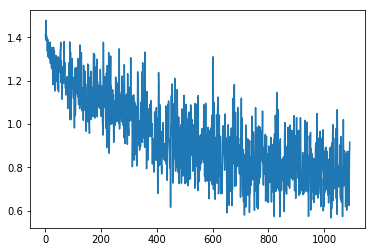

In [61]:
historydir = 'history'
with open(f'{workdir}/01092_train_loss_history.json') as fd:
    losshistory = json.load(fd)
    
plt.plot(losshistory) 

In [62]:
import mytf.validation as mv
print(ts)

2019-12-28T184817Z


#### Similarly, evaluation, got this 
```
InvalidArgumentError: Incompatible shapes: [100,64] vs. [32,64] [Op:Add] name: sequential_2/lstm_11/add/
```

#### Dang also validation failed at the end..
```
InvalidArgumentError: Incompatible shapes: [7,64] vs. [32,64] [Op:Add] name: sequential_2/lstm_11/add/
```
The very last chunk of validation, I have to not include that one... grr..

In [78]:
reload(mv)

<module 'mytf.validation' from '/home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/validation.py'>



  0%|          | 0/10 [00:00<?, ?it/s]

starting validation 2019-12-28T202107Z


W1228 20:21:08.731440 139664612869952 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


 10%|█         | 1/10 [12:54<1:56:14, 774.89s/it]W1228 20:34:03.588593 139664612869952 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


 20%|██        | 2/10 [25:47<1:43:12, 774.07s/it]W1228 20:46:55.499610 139664612869952 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


 30%|███       | 3/10 [38:39<1:30:15, 773.61s/it]W1228 20:59:48.038667 139664612869952 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


 40%|████      | 4/10 [51:40<1:17:35, 775.94s/it]W1228 21:12:49.424139 139664612869952 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


 50%|█████     | 5/

done validation 2019-12-28T223104Z


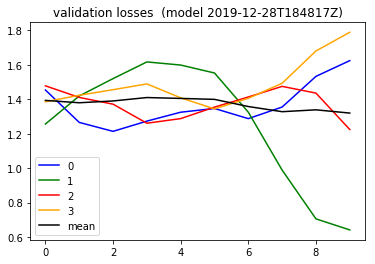

In [79]:
print('starting validation', mu.quickts())
#def wrapwrap():
batch_losses_vec = []

for step in tqdm(np.arange(0, 100, 10)):
    modelname = f'history/{ts}/{str(step).zfill(5)}_model.h5'
    steploss = mv.perf_wrapper(modelname,
                               dataloc=test_loc,
                               eager=True,
                              batch_size=32)
    batch_losses_vec.append([float(x) for x in steploss])
    mv.json_save({'batch_losses_vec': batch_losses_vec,
                  'step': int(step)
              }, 
              f'history/{ts}/{str(step).zfill(5)}_validation_losses.json')
    
print('done validation', mu.quickts())
#####
lossesarr = np.array(batch_losses_vec)
meanlossesarr = np.mean(lossesarr, axis=1)

batch_losses_vec[:5]
#batch_losses_vec = []
#for step in np.arange(0, 1068, 10):
# [2.8359528, 0.45356295, 1.7049086, 4.099845]

plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses  (model {ts})')
plt.legend()


In [80]:
print('starting validation', mu.quickts())
#def wrapwrap():
print('len batch_losses_vec', len(batch_losses_vec))
# batch_losses_vec = []

for step in tqdm(np.arange(100, 200, 10)):
    modelname = f'history/{ts}/{str(step).zfill(5)}_model.h5'
    steploss = mv.perf_wrapper(modelname,
                               dataloc=test_loc,
                               eager=True,
                              batch_size=32)
    batch_losses_vec.append([float(x) for x in steploss])
    mv.json_save({'batch_losses_vec': batch_losses_vec,
                  'step': int(step)
              }, 
              f'history/{ts}/{str(step).zfill(5)}_validation_losses.json')
    
print('done validation', mu.quickts())
#####
lossesarr = np.array(batch_losses_vec)
meanlossesarr = np.mean(lossesarr, axis=1)

batch_losses_vec[:5]
#batch_losses_vec = []
#for step in np.arange(0, 1068, 10):
# [2.8359528, 0.45356295, 1.7049086, 4.099845]

plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses  (model {ts})')
plt.legend()





  0%|          | 0/10 [00:00<?, ?it/s]

starting validation 2019-12-28T225036Z
len batch_losses_vec 10


W1228 22:50:37.497003 139664612869952 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


 10%|█         | 1/10 [12:56<1:56:24, 776.01s/it]W1228 23:03:33.501674 139664612869952 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


 20%|██        | 2/10 [25:55<1:43:36, 777.10s/it]W1228 23:16:33.146059 139664612869952 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


 30%|███       | 3/10 [39:06<1:31:08, 781.22s/it]W1228 23:29:43.982626 139664612869952 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


 40%|████      | 4/10 [52:08<1:18:09, 781.60s/it]W1228 23:42:46.800872 139664612869952 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


KeyboardInterrupt: 

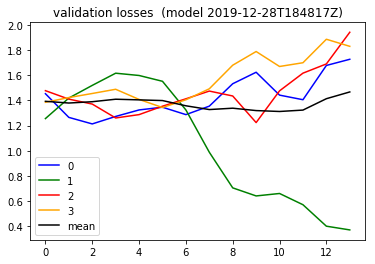

In [81]:
lossesarr = np.array(batch_losses_vec)
meanlossesarr = np.mean(lossesarr, axis=1)

#batch_losses_vec[:5]
#batch_losses_vec = []
#for step in np.arange(0, 1068, 10):
# [2.8359528, 0.45356295, 1.7049086, 4.099845]

plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses  (model {ts})')
plt.legend()


In [44]:
model = tf.keras.layers.LSTM(units=10)
vars(model._layers[0])
#  'activation': <function tensorflow.python.keras.activations.tanh(x)>,
# 'recurrent_activation': <function tensorflow.python.keras.activations.hard_sigmoid(x)>,

{'_obj_reference_counts_dict': <tensorflow.python.training.tracking.object_identity.ObjectIdentityDictionary at 0x7f05ca96ca90>,
 '_dropout_mask': None,
 '_recurrent_dropout_mask': None,
 '_eager_dropout_mask': None,
 '_eager_recurrent_dropout_mask': None,
 '_self_setattr_tracking': True,
 '_trainable': True,
 'stateful': False,
 'built': False,
 'input_spec': None,
 'supports_masking': False,
 '_name': 'lstm_cell_6',
 '_activity_regularizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_callable_losses': [],
 '_losses': [],
 '_eager_losses': [],
 '_metrics': [],
 '_metrics_tensors': {},
 '_mixed_precision_policy': <tensorflow.python.keras.mixed_precision.experimental.policy.Policy at 0x7f05da9248d0>,
 '_dtype': None,
 '_call_convention': <CallConvention.EXPLICIT_INPUTS_ARGUMENT: 1>,
 '_layers': [],
 '_inbound_nodes': [],
 '_outbound_nodes': [],
 '_expects_training_arg': True,
 '_dynamic': False,
 '_initial_weights': None,
 'units': 10,
 'activati